Step 1: Understand the dataset (5 points)
The first thing you should do is to load the CSV file and understand the dataset. It is important to
understand the dataset and examine if there is any missing values or outliers before doing analysis. In
this step, you should write Python scripts to answer the following questions.


1. Are there any missing values in the dataset? (0.5)
2. What is the range of dates in the dataset? (1.5)
3. How many unique customers are there in the dataset? (0.5)
4. How many unique orders are there in the dataset? (0.5)
5. Profile the data to give the standard descriptive statistics for the Sales field. What are the min, max,
variance, and standard deviations? (0.5)
6. Do transaction amounts (sales) in general increase over time (perhaps due to inflation)? (1.5)

# Customer Sales Analysis and Historic CLV Calculation

This notebook performs an in-depth analysis of customer sales data to understand customer behavior and calculate Historic Customer Lifetime Value (CLV).

## Objectives

The primary objectives of this analysis are to:

1.  Understand the dataset, including identifying missing values, data ranges, and key statistics.
2.  Explore the dataset to identify outliers, analyze the impact of discounts on sales and profits, and determine factors affecting sales.
3.  Determine the origin year for each customer to group them into cohorts.
4.  Calculate cumulative transaction amounts for each customer cohort over time.
5.  Calculate the number of new customers by origin year.
6.  Compute the Historic CLV for each customer cohort.
7.  Combine cohort-specific CLV into a single, volume-weighted average CLV curve.
8.  Interpret the results and discuss their implications for the business.

## Analysis Steps

The notebook follows these steps:

1.  **Data Loading and Initial Understanding:**
    *   Load the `customer_sales.csv` dataset into a pandas DataFrame.
    *   Examine the first few rows and check for missing values.
    *   Determine the date range of the data.
    *   Count the number of unique customers and orders.
    *   Calculate descriptive statistics for the 'Sales' field.
    *   Analyze whether transaction amounts increase over time.

2.  **Data Exploration:**
    *   Check for outliers in the 'Sales' data using methods like the IQR.
    *   Analyze the relationship between 'Discount', 'Sales', and 'Profit' through grouping and plotting.
    *   Identify the optimal discount level for maximizing total profit.
    *   Use linear regression to identify factors that affect 'Sales' the most (based on available numeric features).

3.  **Determine Customer Origin Year:**
    *   Identify the first order date for each unique customer.
    *   Extract the origin year from the first order date.

4.  **Calculate Cumulative Transaction Amounts:**
    *   For each customer cohort (grouped by origin year), calculate the cumulative sum of 'Sales' at different age intervals (12, 24, 36, 48, 60, and 72 months from the first order date).

5.  **Calculate Number of New Customers:**
    *   Count the number of unique customers acquired in each origin year.

6.  **Calculate Historic CLV:**
    *   Divide the cumulative transaction amounts (from Step 4) by the number of new customers (from Step 5) for each cohort and age interval to get the Historic CLV per customer.

7.  **Combine Historic CLV:**
    *   Calculate a volume-weighted average of the Historic CLV across all cohorts at each age interval to create a single CLV curve.

8.  **Interpret Results:**
    *   Analyze the Historic CLV trends for different cohorts and the overall weighted-average CLV.
    *   Discuss the spending patterns of customers and their implications for customer retention and acquisition strategies.

## Skills Demonstrated

This notebook showcases skills in:

*   Data Loading and Handling
*   Data Cleaning and Preprocessing
*   Exploratory Data Analysis (EDA)
*   Feature Engineering
*   Cohort Analysis
*   Customer Lifetime Value (CLV) Calculation
*   Data Visualization
*   Interpretation and Communication of Analytical Results

## Usage

To run this notebook, ensure you have the `customer_sales.csv` file in the appropriate directory or update the file path in the notebook. The required libraries (pandas, numpy, matplotlib, sklearn) should be installed in your environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 1: Understand the dataset (5 points)
The first thing you should do is to load the CSV file and understand the dataset. It is important to
understand the dataset and examine if there is any missing values or outliers before doing analysis. In
this step, you should write Python scripts to answer the following questions.
1. Are there any missing values in the dataset? (0.5)
2. What is the range of dates in the dataset? (1.5)
3. How many unique customers are there in the dataset? (0.5)
4. How many unique orders are there in the dataset? (0.5)
5. Profile the data to give the standard descriptive statistics for the Sales field. What are the min, max,
variance, and standard deviations? (0.5)
6. Do transaction amounts (sales) in general increase over time (perhaps due to inflation)? (1.5)

First 5 rows of the dataset:


,Order ID,Order Date,Customer Name,Country,State,City,Region,Segment,Ship Mode,Category,Sub-Category,Product Name,Discount,Sales,Profit,Quantity
0,BN-2011-7407039,2011-01-01,Ruby Patel,Sweden,Stockholm,Stockholm,North,Home Office,Economy Plus,Office Supplies,Paper,"Enermax Note Cards, Premium",0.5,45.0,-26.0,3.0
1,AZ-2011-9050313,2011-01-03,Summer Hayward,United Kingdom,England,Southport,North,Consumer,Economy,Furniture,Bookcases,"Dania Corner Shelving, Traditional",0.0,854.0,290.0,7.0
2,AZ-2011-6674300,2011-01-04,Devin Huddleston,France,Auvergne-Rhône-Alpes,Valence,Central,Consumer,Economy,Office Supplies,Art,"Binney & Smith Sketch Pad, Easy-Erase",0.0,140.0,21.0,3.0
3,BN-2011-2819714,2011-01-04,Mary Parker,United Kingdom,England,Birmingham,North,Corporate,Economy,Office Supplies,Art,"Boston Markers, Easy-Erase",0.5,27.0,-22.0,2.0
4,BN-2011-2819714,2011-01-04,Mary Parker,United Kingdom,England,Birmingham,North,Corporate,Economy,Office Supplies,Storage,"Eldon Folders, Single Width",0.5,17.0,-1.0,2.0



Missing values per column:
Order ID          0
Order Date        6
Customer Name     1
Country           1
State             4
City              4
Region            0
Segment           1
Ship Mode         5
Category          5
Sub-Category      0
Product Name      0
Discount          7
Sales             2
Profit           13
Quantity         13
dtype: int64

Date range: 2011-01-01 to 2014-12-31

Unique customers: 792
Unique orders: 4117

Sales descriptive statistics:
min: -110.00
max: 206000.00
variance: 10355997.72
std_dev: 3218.07


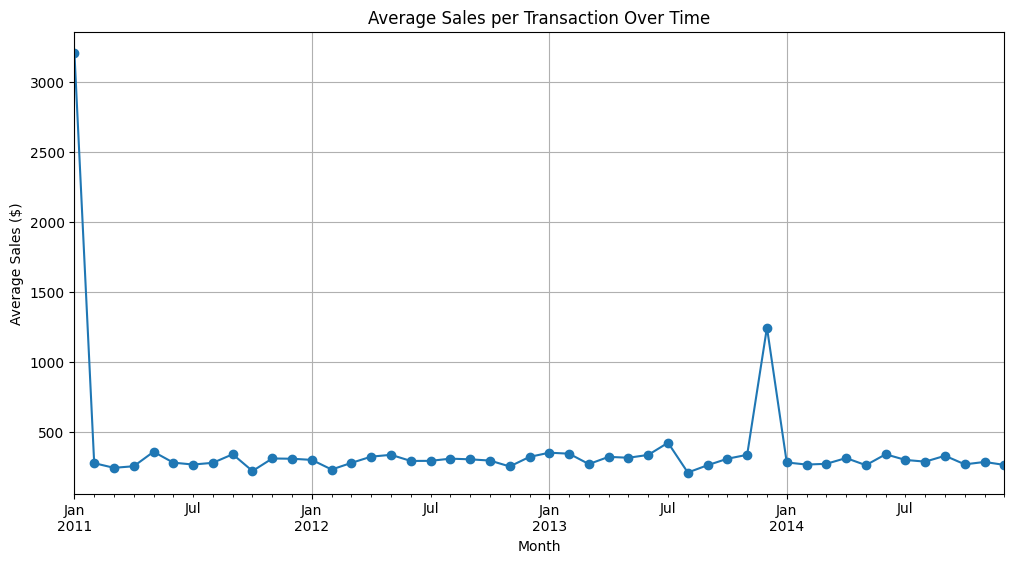

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("customer_sales.csv")

# Clean Sales (remove $ and convert to numeric)
df['Sales'] = df['Sales'].astype(str).str.replace(r'[^0-9.\-]', '', regex=True)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

# Parse dates in MM/DD/YY format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y', errors='coerce')

print("First 5 rows of the dataset:")
display(df.head())

print("\nMissing values per column:")
print(df.isnull().sum())

date_min = df['Order Date'].min()
date_max = df['Order Date'].max()
print(f"\nDate range: {date_min.date()} to {date_max.date()}")

num_customers = df['Customer Name'].nunique()
print(f"\nUnique customers: {num_customers}")

num_orders = df['Order ID'].nunique()
print(f"Unique orders: {num_orders}")

sales_stats = {
    "min": df['Sales'].min(),
    "max": df['Sales'].max(),
    "variance": df['Sales'].var(),
    "std_dev": df['Sales'].std()
}
print("\nSales descriptive statistics:")
for k, v in sales_stats.items():
    print(f"{k}: {v:.2f}")

monthly_sales = df.groupby(df['Order Date'].dt.to_period("M"))['Sales'].mean()
plt.figure(figsize=(12,6))
monthly_sales.plot(marker='o')
plt.title("Average Sales per Transaction Over Time")
plt.xlabel("Month")
plt.ylabel("Average Sales ($)")
plt.grid(True)
plt.show()



Missing values per column:
Order ID          0
Order Date        6
Customer Name     1
Country           1
State             4
City              4
Region            0
Segment           1
Ship Mode         5
Category          5
Sub-Category      0
Product Name      0
Discount          7
Sales             2
Profit           13
Quantity         13
dtype: int64

Date range: 2011-01-01 to 2014-12-31

Unique customers: 792
Unique orders: 4117

Sales descriptive statistics:
min: -110.00
max: 206000.00
variance: 10355997.72
std_dev: 3218.07


 Average sales seems to vary within a range but stays constant overall but seems like the inflation does not have an effect on it


Step 2: Explore the dataset (8 points)
Next, answer a number of preliminary questions before calculating customer lifetime value. In this step,
you should write Python scripts to help you answer the following questions.
1. Are there any outliers or values that don’t make sense? You can use statistical tests to check for
outliers. Or, you can simply plot the histogram of the Sales and see if there is any value that
appears to be abnormal. (Hint, is there any value that appears to be abnormally large or small?
Could it be caused by bad entries (e.g. forgetting a decimal separator?). If there are outliers ,
how would you treat them? (4)
2. Does giving discounts increase sales and/or profits? Make a graph to show that. Comment on
what happens at 80% discount level, and what’s the optimum level for maximizing total profit.
(2)
3. What factors affect the sales the most? You can run a simple regression to understand the
impact. (2)

Outliers detected using IQR: 879

Sample outliers:
           Order ID       Customer Name     Sales
1   AZ-2011-9050313      Summer Hayward     854.0
9   AZ-2011-2918397  Fredrick Beveridge     716.0
10  BN-2011-3248724         Archer Hort     987.0
17  AZ-2011-7053593       Gracie Powell    1384.0
28  BN-2011-4913858        Julian Dobie  198000.0


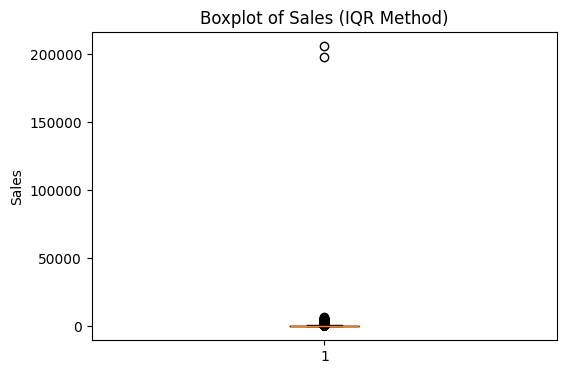

In [ ]:
#1. Are there any outliers or values that don’t make sense? You can use statistical tests to check for
outliers. Or, you can simply plot the histogram of the Sales and see if there is any value that
# Outlier detection using IQR method
q1 = df['Sales'].quantile(0.25)
q3 = df['Sales'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

iqr_outliers = df[(df['Sales'] < lower) | (df['Sales'] > upper)]
print(f"Outliers detected using IQR: {len(iqr_outliers)}")

print("\nSample outliers:")
print(iqr_outliers[['Order ID','Customer Name','Sales']].head())

# Optional: boxplot to visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.boxplot(df['Sales'].dropna(), vert=True)
plt.title("Boxplot of Sales (IQR Method)")
plt.ylabel("Sales")
plt.show()





No there are no sales outliers that are abnormal. Although some lie outside the IQR, Given its a sales chart, there could be orders where a very small or large sale occured. Usually outliers are removed from the dataset. Other method is to normalize them using log or square root method

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

df = df.copy()

df['Sales'] = df['Sales'].astype(str).str.replace(r'[^0-9.\-]', '', regex=True)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y', errors='coerce')

rules = {}
rules['sales_nonpositive'] = df[(df['Sales'].isna()) | (df['Sales'] <= 0)]
rules['quantity_invalid'] = df[(df['Quantity'].isna()) | (df['Quantity'] <= 0) | (df['Quantity'] % 1 != 0)]
rules['date_invalid'] = df[df['Order Date'].isna()]

summary = {k: len(v) for k, v in rules.items()}
for k, v in summary.items():
    print(f"{k}: {v}")

for k, v in rules.items():
    if len(v) > 0:
        print(f"\n{k} samples:")
        display(v.head(5)[['Order ID','Order Date','Customer Name','Sales','Profit','Quantity','Discount']])


sales_nonpositive: 6
quantity_invalid: 13
date_invalid: 6

sales_nonpositive samples:


,Order ID,Order Date,Customer Name,Sales,Profit,Quantity,Discount
180,BN-2011-1399750,2011-03-15,Wanda Wingert,-110.0,4.0,1.0,0.1
381,AZ-2011-309750,2011-05-19,Milla Hollinworth,0.0,0.0,1.0,0.0
557,AZ-2011-7543304,2011-06-22,Lane Taylor,NaN,123.0,7.0,0.1
561,AZ-2011-8847796,2011-06-24,Walter Aguilar,NaN,55.0,7.0,0.0
7327,AZ-2014-6494772,2014-10-16,Kian Sykes,-70.0,24.0,3.0,0.0



quantity_invalid samples:


,Order ID,Order Date,Customer Name,Sales,Profit,Quantity,Discount
1125,AZ-2011-8648970,2011-11-04,Dylan Dry,45.0,NaN,NaN,NaN
1126,AZ-2011-8421926,2011-11-04,Peter Daly,171.0,NaN,NaN,NaN
1127,AZ-2011-8421926,2011-11-04,Peter Daly,55.0,NaN,NaN,NaN
1128,BN-2011-183687,2011-11-04,Paige Hopley,126.0,NaN,NaN,NaN
1129,BN-2011-183687,2011-11-04,Paige Hopley,17.0,NaN,NaN,NaN



date_invalid samples:


,Order ID,Order Date,Customer Name,Sales,Profit,Quantity,Discount
621,AZ-2011-7849219,NaT,Abby Mei,178.0,52.0,4.0,0.0
622,AZ-2011-7849219,NaT,Abby Mei,123.0,60.0,3.0,0.0
623,BN-2011-2343184,NaT,Rory Martindale,106.0,-23.0,3.0,0.3
624,BN-2011-2343184,NaT,Rory Martindale,79.0,35.0,5.0,0.0
625,BN-2011-2343184,NaT,Rory Martindale,34.0,10.0,2.0,0.0


Here date outliers can be removed as we are trying to find Lifetime CLV, so every row with an invalid date will be removed, also we can remove negative quantity and sales as this will be improbable. It is alright if we dont remove these also as they are so small in number. this wont affect a large dataset like ours which has 4000 rows.Here we are choosing not to remove these

   Discount_lvl  txns   avg_sales   avg_profit  total_sales  total_profit
0           0.0  4901  293.298306    63.814936    1437455.0      312757.0
1           0.1  1312  439.359756    72.681402     576440.0       95358.0
2           0.2   395  564.397468    41.718987     222937.0       16479.0
3           0.3    40  123.800000   -15.875000       4952.0        -635.0
4           0.4   282  393.546099   -97.865248     110980.0      -27598.0
5           0.5   982  373.033605   -89.086558     366319.0      -87483.0
6           0.6    96  206.760417  -155.718750      19849.0      -14949.0
7           0.7    20  455.800000  -537.850000       9116.0      -10757.0
8           0.8     3   46.333333  -142.000000        139.0        -426.0
9           0.9     1  555.000000 -1925.000000        555.0       -1925.0


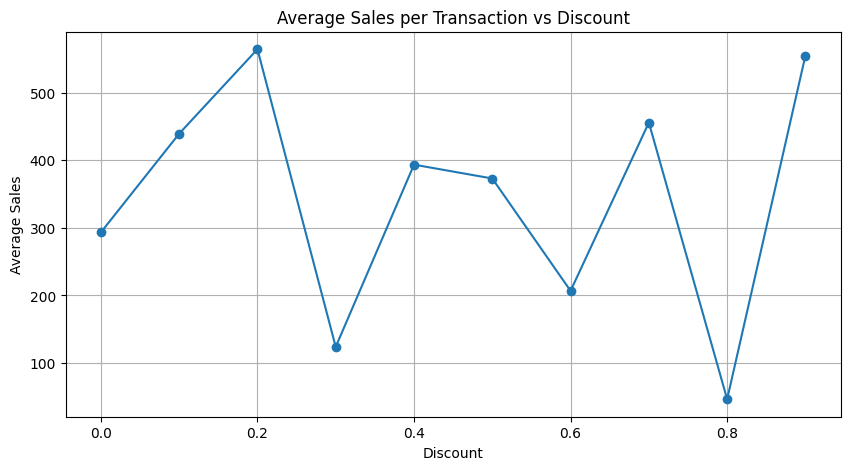

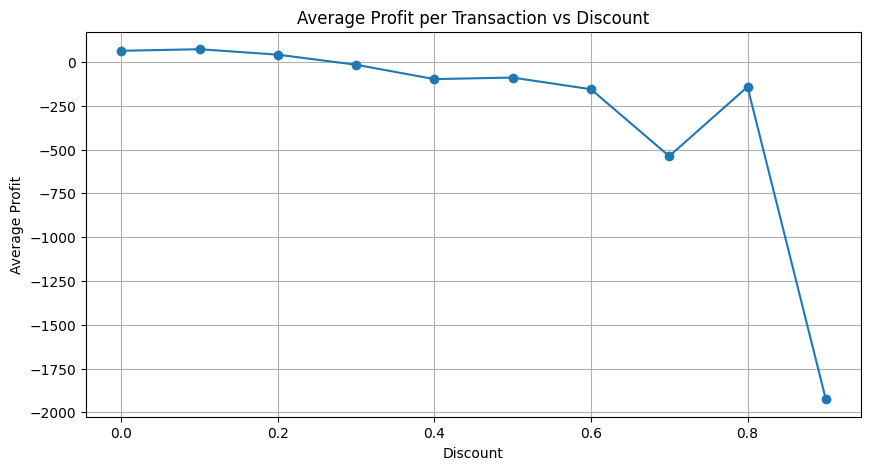

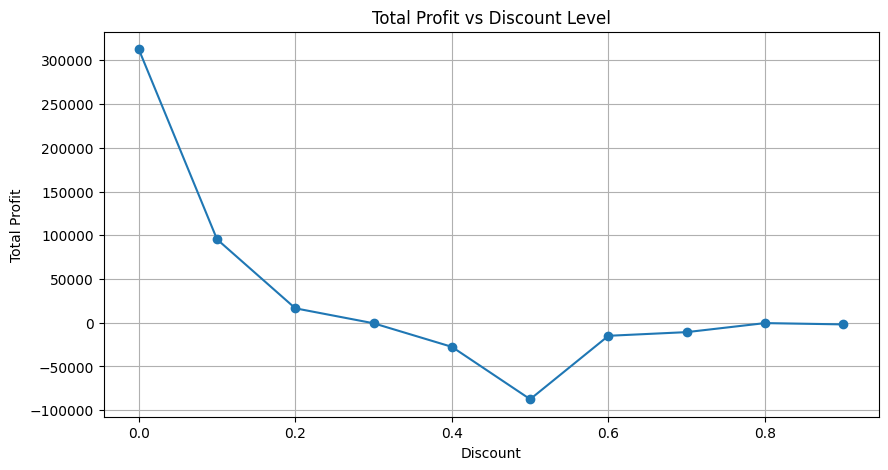

Optimal discount for maximizing TOTAL profit: 0.00 (total profit = 312757.00)
80% discount level stats:
   txns  avg_sales  avg_profit  total_profit
8     3  46.333333      -142.0        -426.0


In [ ]:
#2. Does giving discounts increase sales and/or profits? Make a graph to show that. Comment on
# what happens at 80% discount level, and what’s the optimum level for maximizing total profit.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

d = df.dropna(subset=['Discount','Sales','Profit']).copy()
d['Discount_lvl'] = d['Discount'].round(2)

discount_summary = (
    d.groupby('Discount_lvl')
     .agg(
         txns=('Discount_lvl','size'),
         avg_sales=('Sales','mean'),
         avg_profit=('Profit','mean'),
         total_sales=('Sales','sum'),
         total_profit=('Profit','sum')
     )
     .reset_index()
     .sort_values('Discount_lvl')
)

print(discount_summary)

plt.figure(figsize=(10,5))
plt.plot(discount_summary['Discount_lvl'], discount_summary['avg_sales'], marker='o')
plt.title('Average Sales per Transaction vs Discount')
plt.xlabel('Discount')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(discount_summary['Discount_lvl'], discount_summary['avg_profit'], marker='o')
plt.title('Average Profit per Transaction vs Discount')
plt.xlabel('Discount')
plt.ylabel('Average Profit')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(discount_summary['Discount_lvl'], discount_summary['total_profit'], marker='o')
plt.title('Total Profit vs Discount Level')
plt.xlabel('Discount')
plt.ylabel('Total Profit')
plt.grid(True)
plt.show()

opt_idx = discount_summary['total_profit'].idxmax()
opt_discount = float(discount_summary.loc[opt_idx, 'Discount_lvl'])
opt_total_profit = float(discount_summary.loc[opt_idx, 'total_profit'])
print(f"Optimal discount for maximizing TOTAL profit: {opt_discount:.2f} (total profit = {opt_total_profit:.2f})")

eighty = discount_summary[discount_summary['Discount_lvl'] == 0.80]
if not eighty.empty:
    print("80% discount level stats:")
    print(eighty[['txns','avg_sales','avg_profit','total_profit']])
else:
    close_idx = (discount_summary['Discount_lvl'] - 0.80).abs().idxmin()
    close_row = discount_summary.loc[close_idx]
    print(f"No exact 0.80 level found. Closest level: {close_row['Discount_lvl']:.2f} with total profit {close_row['total_profit']:.2f} and avg profit {close_row['avg_profit']:.2f}")



Average sales wrt to discount varys. It doesnt have a clear relationship, at first average sales increases until 20% then, average sale decreases, after which it again varys between increasing and decreasing.

Average profit vs discount is clear. It plateus until 70% discount then,decreases for a small while, increases and shoes a huge drop at around 90%

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

df_ = df.copy()

df_['Sales'] = df_['Sales'].astype(str).str.replace(r'[^0-9.\-]', '', regex=True)
df_['Sales'] = pd.to_numeric(df_['Sales'], errors='coerce')

for c in ['Discount','Profit','Quantity']:
    if c in df_.columns:
        df_[c] = pd.to_numeric(df_[c], errors='coerce')

num_cols_all = df_.select_dtypes(include='number').columns.tolist()
drop_cols = [c for c in ['Sales','Order Date','Order ID'] if c in num_cols_all]
feature_cols = [c for c in num_cols_all if c not in drop_cols]

d = df_[feature_cols + ['Sales']].dropna().copy()
X = d[feature_cols]
y = d['Sales']

lr = LinearRegression()
lr.fit(X, y)
r2 = lr.score(X, y)

sd_y = y.std(ddof=1)
sd_X = X.std(axis=0, ddof=1).replace(0, np.nan)
std_beta = lr.coef_ * (sd_X.values / sd_y)

coef_df = pd.DataFrame({
    'feature': X.columns,
    'coef': lr.coef_,
    'std_beta': std_beta
}).assign(abs_std_beta=lambda x: x['std_beta'].abs()).sort_values('abs_std_beta', ascending=False)

print(f"R^2: {r2:.4f}")
print("\nTop factors by absolute standardized effect on Sales (numeric-only features):")
print(coef_df[['feature','coef','std_beta']].head(15).to_string(index=False))


R^2: 0.0079

Top factors by absolute standardized effect on Sales (numeric-only features):
 feature       coef  std_beta
  Profit   1.154193  0.063607
Quantity  87.062874  0.059515
Discount 546.892221  0.031091


Based on this Discount affects sales the most

Step 3: Determine origin year of customers (1)
Some of the underlying customers are brand new and others have been customers for almost five
years. The newer customers will have (generally) spent less on average than the old ones. You need to
separate the customers into groups based on how long ago they were acquired (e.g. customers
acquired in 2010, vs customers acquired in 2011, ...). First, assign customers into different groups based
on the date of acquisition (origin year). For instance, the earliest transaction date that can be found for
customer 2 in the dataset is 5/15/12. Then we assign customer 2 into group 2012 as this customer was
acquired in the year 2012. Write Python scripts to assign the appropriate origin year to all customers,

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("customer_sales.csv")

required_cols = {'Order Date','Customer Name'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

dt_primary = pd.to_datetime(df['Order Date'], format='%m/%d/%y', errors='coerce')
dt_fallback = pd.to_datetime(df.loc[dt_primary.isna(), 'Order Date'], errors='coerce', infer_datetime_format=True)
df['Order Date'] = dt_primary
df.loc[dt_primary.isna(), 'Order Date'] = dt_fallback

cust_first = (
    df.loc[df['Order Date'].notna(), ['Customer Name','Order Date']]
      .groupby('Customer Name', as_index=False)['Order Date'].min()
      .rename(columns={'Order Date':'First Order Date'})
)
cust_first['Origin Year'] = cust_first['First Order Date'].dt.year.astype('Int64')

customers_with_origin = cust_first[['Customer Name','Origin Year']].copy()

df_with_origin = df.merge(customers_with_origin, on='Customer Name', how='left')

print(customers_with_origin.head(10))
print("\nOrigin Year counts (customers):")
print(customers_with_origin['Origin Year'].value_counts(dropna=False).sort_index())

print("\nTransactions with Origin Year (preview):")
print(df_with_origin[['Customer Name','Order Date','Origin Year']].head(10))

print("\nTransactions per Origin Year:")
print(df_with_origin['Origin Year'].value_counts(dropna=False).sort_index())


      Customer Name  Origin Year
0     Aaron Bootman         2011
1  Aaron Cunningham         2011
2       Aaron Davey         2011
3   Aaron Macrossan         2011
4       Abbie Perry         2011
5       Abby Colebe         2011
6          Abby Mei         2013
7     Abby Muramats         2011
8  Abigail Humffray         2012
9        Ada Dalton         2011

Origin Year counts (customers):
Origin Year
2011    492
2012    204
2013     79
2014     17
Name: count, dtype: Int64

Transactions with Origin Year (preview):
        Customer Name Order Date  Origin Year
0          Ruby Patel 2011-01-01         2011
1      Summer Hayward 2011-01-03         2011
2    Devin Huddleston 2011-01-04         2011
3         Mary Parker 2011-01-04         2011
4         Mary Parker 2011-01-04         2011
5        Daniel Burke 2011-01-05         2011
6        Daniel Burke 2011-01-05         2011
7  Fredrick Beveridge 2011-01-07         2011
8  Fredrick Beveridge 2011-01-07         2011
9  Fredrick Beve

/tmp/ipython-input-3627895787.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt_fallback = pd.to_datetime(df.loc[dt_primary.isna(), 'Order Date'], errors='coerce', infer_datetime_format=True)


Step 4: Calculate cumulative transaction amounts (2)
Now, calculate the cumulative transaction amounts (sales) for customers in each group of origin year.
Your output should be something similar to the table below. In the table, each row represents the
cumulative amount for customers of each origin year. Each column represents the cumulative amounts
at age 12, 24, 36, 48, 60, and 72 months. Note: age represents the time elapsed since the start of each
customer group.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("customer_sales.csv")

if "SubCategory" in df.columns and "Sub-Category" not in df.columns:
    df = df.rename(columns={"SubCategory": "Sub-Category"})
if "Product\nName" in df.columns and "Product Name" not in df.columns:
    df = df.rename(columns={"Product\nName": "Product Name"})

df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y', errors='coerce')
mask = df['Order Date'].isna()
if mask.any():
    df.loc[mask, 'Order Date'] = pd.to_datetime(df.loc[mask, 'Order Date'], errors='coerce', infer_datetime_format=True)

df['Sales'] = df['Sales'].astype(str).str.replace(r'[^0-9.\-]', '', regex=True)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

cust_first = (
    df.loc[df['Order Date'].notna(), ['Customer Name','Order Date']]
      .groupby('Customer Name', as_index=False)['Order Date'].min()
      .rename(columns={'Order Date':'First Order Date'})
)
cust_first['Origin Year'] = cust_first['First Order Date'].dt.year

d = df.merge(cust_first, on='Customer Name', how='left').dropna(subset=['Order Date','First Order Date','Sales'])

ages = [12, 24, 36, 48, 60, 72]
series_by_age = []
for m in ages:
    within = d['Order Date'] <= (d['First Order Date'] + pd.DateOffset(months=m))
    s = d.loc[within].groupby('Origin Year', as_index=True)['Sales'].sum().rename(str(m))
    series_by_age.append(s)

amount_cmltv = pd.concat(series_by_age, axis=1)

all_years = pd.Index(range(int(cust_first['Origin Year'].min()), int(cust_first['Origin Year'].max())+1), name='Origin')
amount_cmltv = amount_cmltv.reindex(all_years)

amount_cmltv = amount_cmltv.round(2)

amount_cmltv = amount_cmltv.reset_index()

amount_cmltv.insert(
    1,
    'Origin Span',
    amount_cmltv['Origin'].astype('Int64').astype(str) + "-01-01 – " + amount_cmltv['Origin'].astype('Int64').astype(str) + "-12-31"
)

amount_cmltv


/tmp/ipython-input-759107491.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df.loc[mask, 'Order Date'] = pd.to_datetime(df.loc[mask, 'Order Date'], errors='coerce', infer_datetime_format=True)


,Origin,Origin Span,12,24,36,48,60,72
0,2011,2011-01-01 – 2011-12-31,768649.0,1138165.0,1515614.0,1810358.0,1810358.0,1810358.0
1,2012,2012-01-01 – 2012-12-31,274212.0,467576.0,577810.0,577810.0,577810.0,577810.0
2,2013,2013-01-01 – 2013-12-31,315564.0,354919.0,354919.0,354919.0,354919.0,354919.0
3,2014,2014-01-01 – 2014-12-31,12108.0,12108.0,12108.0,12108.0,12108.0,12108.0


Step 5: Calculate the number of new customers (1)
• Again using Python, calculate the number of new customers by origin year in each year. Your
output should be similar to the table below (again, you will have slightly different numbers
because the input data is different for the assignment):


In [ ]:
import pandas as pd
import numpy as np

# Load
df = pd.read_csv("customer_sales.csv")

# Parse dates (primary MM/DD/YY, then fallback)
dt_primary = pd.to_datetime(df['Order Date'], format='%m/%d/%y', errors='coerce')
dt_fallback = pd.to_datetime(df.loc[dt_primary.isna(), 'Order Date'], errors='coerce', infer_datetime_format=True)
df['Order Date'] = dt_primary
df.loc[dt_primary.isna(), 'Order Date'] = dt_fallback

# Each customer's first purchase (origin) and origin year
cust_first = (
    df.loc[df['Order Date'].notna(), ['Customer Name','Order Date']]
      .groupby('Customer Name', as_index=False)['Order Date'].min()
      .rename(columns={'Order Date':'First Order Date'})
)
cust_first['Origin Year'] = cust_first['First Order Date'].dt.year

# Count new customers in each origin year
counts_by_origin = cust_first['Origin Year'].value_counts().sort_index()
counts_by_origin.index.name = 'Origin'

# Build NewCustomers.cmltv table for all calendar years in the data
ages = [12, 24, 36, 48, 60, 72]
all_years = pd.Index(
    range(int(df['Order Date'].dt.year.min()), int(df['Order Date'].dt.year.max()) + 1),
    name='Origin'
)

newcust_cmltv = pd.DataFrame(index=all_years)
for a in ages:
    newcust_cmltv[str(a)] = counts_by_origin  # same count in every age column
newcust_cmltv = newcust_cmltv.reset_index()

# Optional: add a display span column like the example
newcust_cmltv.insert(
    1,
    'Origin Span',
    newcust_cmltv['Origin'].astype('Int64').astype(str) + "-01-01 – " +
    newcust_cmltv['Origin'].astype('Int64').astype(str) + "-12-31"
)

newcust_cmltv


/tmp/ipython-input-1663466616.py:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt_fallback = pd.to_datetime(df.loc[dt_primary.isna(), 'Order Date'], errors='coerce', infer_datetime_format=True)


,Origin,Origin Span,12,24,36,48,60,72
0,2011,2011-01-01 – 2011-12-31,492,492,492,492,492,492
1,2012,2012-01-01 – 2012-12-31,204,204,204,204,204,204
2,2013,2013-01-01 – 2013-12-31,79,79,79,79,79,79
3,2014,2014-01-01 – 2014-12-31,17,17,17,17,17,17


Step 6: Historic CLV (2)
• Finally, you are ready to calculate the Historic CLV. Dividing the Amount.cmltv triangle by the
NewCustomers.cmltv triangle will give us annual measurements of the cumulative amount
spent per customer in each group of annually acquired customers. This is also known as Historic

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("customer_sales.csv")

dt_primary = pd.to_datetime(df['Order Date'], format='%m/%d/%y', errors='coerce')
dt_fallback = pd.to_datetime(df.loc[dt_primary.isna(), 'Order Date'], errors='coerce', infer_datetime_format=True)
df['Order Date'] = dt_primary
df.loc[dt_primary.isna(), 'Order Date'] = dt_fallback

df['Sales'] = df['Sales'].astype(str).str.replace(r'[^0-9.\-]', '', regex=True)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

cust_first = (
    df.loc[df['Order Date'].notna(), ['Customer Name','Order Date']]
      .groupby('Customer Name', as_index=False)['Order Date'].min()
      .rename(columns={'Order Date':'First Order Date'})
)
cust_first['Origin Year'] = cust_first['First Order Date'].dt.year

d = df.merge(cust_first, on='Customer Name', how='left').dropna(subset=['Order Date','First Order Date','Sales'])

ages = [12,24,36,48,60,72]

series_by_age = []
for m in ages:
    within = d['Order Date'] <= (d['First Order Date'] + pd.DateOffset(months=m))
    s = d.loc[within].groupby('Origin Year', as_index=True)['Sales'].sum().rename(str(m))
    series_by_age.append(s)
amount_cmltv = pd.concat(series_by_age, axis=1)

all_years = pd.Index(range(int(df['Order Date'].dt.year.min()), int(df['Order Date'].dt.year.max())+1), name='Origin')
amount_cmltv = amount_cmltv.reindex(all_years)

counts_by_origin = cust_first['Origin Year'].value_counts().sort_index()
newcust_cmltv = pd.DataFrame(index=all_years)
for a in ages:
    newcust_cmltv[str(a)] = counts_by_origin

with np.errstate(divide='ignore', invalid='ignore'):
    historic_clv = amount_cmltv / newcust_cmltv
historic_clv = historic_clv.round(2)

hc = historic_clv.reset_index()
hc.insert(1, 'Origin Span', hc['Origin'].astype('Int64').astype(str) + "-01-01 – " + hc['Origin'].astype('Int64').astype(str) + "-12-31")
hc


/tmp/ipython-input-2931310049.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt_fallback = pd.to_datetime(df.loc[dt_primary.isna(), 'Order Date'], errors='coerce', infer_datetime_format=True)


,Origin,Origin Span,12,24,36,48,60,72
0,2011,2011-01-01 – 2011-12-31,1562.29,2313.34,3080.52,3679.59,3679.59,3679.59
1,2012,2012-01-01 – 2012-12-31,1344.18,2292.04,2832.40,2832.40,2832.40,2832.40
2,2013,2013-01-01 – 2013-12-31,3994.48,4492.65,4492.65,4492.65,4492.65,4492.65
3,2014,2014-01-01 – 2014-12-31,712.24,712.24,712.24,712.24,712.24,712.24


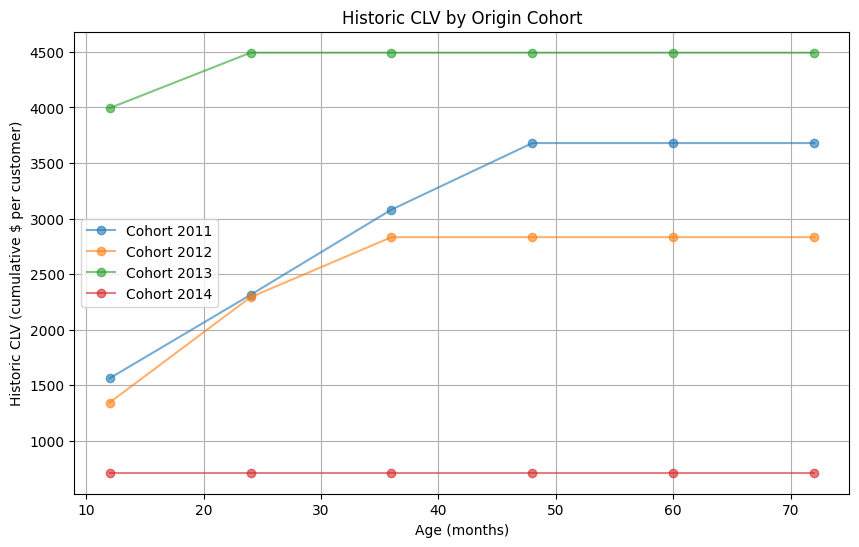

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for _, row in hc.iterrows():
    y = row[[str(a) for a in ages]].values.astype(float)
    if np.isfinite(y).any():
        plt.plot(ages, y, marker='o', alpha=0.6, label=f"Cohort {row['Origin']}")
plt.xlabel("Age (months)")
plt.ylabel("Historic CLV (cumulative $ per customer)")
plt.title("Historic CLV by Origin Cohort")
plt.legend()
plt.grid(True)
plt.show()




At this point, we’d like to combine all of our data to create a single curve of Historic CLV. A simple, but
effective approach to doing this is to take a volume-weighted average of the Historic CLV for each
group at each Age, weighted by the number of customers in each group. For example, we’d get:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ages we are using
ages = [12,24,36,48,60,72]

# compute weighted average across cohorts
weights = newcust_cmltv.loc[historic_clv.index]
vw = (historic_clv * weights).sum(axis=0, skipna=True) / weights.where(historic_clv.notna()).sum(axis=0, skipna=True)
vw = vw.astype(float)

# make a clean table
vw_table = pd.DataFrame({
    "Age": ages,
    "HistoricCLV": vw.values.round(2)
})
print(vw_table)




   Age  HistoricCLV
0   12      1730.47
1   24      2490.87
2   36      3106.63
3   48      3478.78
4   60      3478.78
5   72      3478.78


Step 7: Interpreting your results (1)
Interpret the historic CLV and briefly answer the following questions: -
1. How much have customers acquired in 2011 spent to date?
Based on the CLV calculations all customers acquired in 2011, till date 2017 have spent  - 1810358.0
2. Does each group of customers exhibit similar or different patterns of spending? What’s the
implication for the business?

All groups exhibit that they tend to increase their value for sometime, by buying for a few years, that means they are return customers for a few years, after which it starts plataueing.
customers acquired in 2014 dont fall under this a there probably isnt enough data to see a trend

this implies that the business can expect sales from a customer for around ~4  years, after which their CLV is constant, so after a number of years, new customers will have to be found to replace the customers of these years of origin
